In [26]:
!pip install mlxtend machine-learning-datasets

In [27]:
import math
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
cvd_df = mldatasets.load("cardiovascular-disease")
cvd_df.info()
# age -> in days
# height -> cm
# weight -> kg
# gender -> 1: female, 2: male
# ap_hi -> sistolic blood pressure (arterial presure). Normal value < 120mmHg
# ap_lo -> diastolic blod presure
# colesterol -> 1:normal, 2: above, 3: well above normal
# gluc: -> 1:normal, 2: above, 3: well above normal
# all the features are objective except smoke an alco and active that are subjective wich represents if they are smokers or drinekers
# or not or if the person is active
# cardio binary where 0 is not CVD (cardiovascular desease) and wan is CVD

https://raw.githubusercontent.com/caravanuden/cardio/master/cardio_train.csv downloaded to /content/data/cardio_train.csv
1 dataset files found in /content/data folder
parsing /content/data/cardio_train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [29]:
# no sense to use days of life, it is better to use range of age based on years old
cvd_df['age'] = cvd_df['age'] / 365.24 # no data loss because we use decimals at the division (años bisiestos)

In [30]:
cvd_df.describe(percentiles=[.01,.99]).transpose()

,count,mean,std,min,1%,50%,99%,max
age,70000.0,53.304309,6.755152,29.564122,39.606834,53.945351,64.311138,64.924433
gender,70000.0,1.349571,0.476838,1.000000,1.000000,1.000000,2.000000,2.000000
height,70000.0,164.359229,8.210126,55.000000,147.000000,165.000000,184.000000,250.000000
weight,70000.0,74.205690,14.395757,10.000000,48.000000,72.000000,117.000000,200.000000
ap_hi,70000.0,128.817286,154.011419,-150.000000,90.000000,120.000000,180.000000,16020.000000
ap_lo,70000.0,96.630414,188.472530,-70.000000,60.000000,80.000000,1000.000000,11000.000000
cholesterol,70000.0,1.366871,0.680250,1.000000,1.000000,1.000000,3.000000,3.000000
gluc,70000.0,1.226457,0.572270,1.000000,1.000000,1.000000,3.000000,3.000000
smoke,70000.0,0.088129,0.283484,0.000000,0.000000,0.000000,1.000000,1.000000
alco,70000.0,0.053771,0.225568,0.000000,0.000000,0.000000,1.000000,1.000000


In [31]:
# anomalies detected: blood pressure (ap_lo, ap_hi) can not be negattive and the highest ever record is 370 not 16020 or 11000
incorrect_l = cvd_df[
    (cvd_df['ap_hi']>370)
    | (cvd_df['ap_hi'] <= 40)
    | (cvd_df['ap_lo'] > 370)
    | (cvd_df['ap_lo'] <= 40)
].index

print(len(incorrect_l)/cvd_df.shape[0]) # wrong data

0.017728571428571427


In [32]:
# as we are not experts in this domain, we are just going to delete this wrong data
cvd_df.drop(incorrect_l, inplace=True) # inplace = no copy to be returned

# never ap_hi should be lower than ap_low
cvd_df = cvd_df[cvd_df['ap_hi'] >= cvd_df['ap_lo']].reset_index(drop=True)

# split in X, y and test and validation dadta
y = cvd_df['cardio']
X = cvd_df.drop(['cardio'], axis=1).copy()

# use random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.15, random_state=9
)

In [33]:
# train de model and print summary
log_model = sm.Logit(y_train, sm.add_constant(X_train))
log_result = log_model.fit()
print(log_result.summary2())
# looks like the most important features are cholesterol and active (higher weights)

Optimization terminated successfully.
         Current function value: 0.562145
         Iterations 6
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: cardio           Pseudo R-squared: 0.189     
Date:               2024-01-16 12:03 AIC:              65636.3972
No. Observations:   58359            BIC:              65744.0896
Df Model:           11               Log-Likelihood:   -32806.   
Df Residuals:       58347            LL-Null:          -40448.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     6.0000           Scale:            1.0000    
-----------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-----------------------------------------------------------------
const         -11.1677   0.2507 -44.5530 0.0000 -11.6590 -10.6764
age             0.0504   0.0015  34.3350 0.0000   0.0475   0.0532


In [34]:
# see the results in a more interpretable way
np.exp(log_result.params).sort_values(ascending=False)
# exponential because the coefficients are the log odds(probability of a positive case)
# what does it means now.
# the odds of CVD increase by a factor of 1.64 for each additional unit of cholesterol, provided
# every other feature stays unchaged
# higher odd doesnt mean more feature importance because every feature have different scales
# thats why we sould calculate the std_deviation in order to give meaning to this probabilities
# we have to check also the P>z columns which if any feature have a value higher than 0.05 it means that there
# is no statistical evidence that it affects the predicted score. We will delete gender feature for this reason

cholesterol    1.645409
ap_hi          1.057123
age            1.051662
ap_lo          1.011482
weight         1.010800
height         0.996614
gender         0.994480
gluc           0.887356
smoke          0.865710
alco           0.825331
active         0.782065
const          0.000014
dtype: float64

In [35]:
np.std(X_train,0)

age             6.753314
gender          0.476652
height          8.186996
weight         14.331368
ap_hi          16.682047
ap_lo           9.434014
cholesterol     0.678979
gluc            0.570598
smoke           0.283529
alco            0.224476
active          0.396201
dtype: float64

In [36]:
coefs = log_result.params.drop(labels=['const','gender'])
stdv = np.std(X_train, 0).drop(labels='gender')
abs(coefs*stdv).sort_values(ascending=False)
# this can be interpreted as an approximation of risk factors from high to low
# according to the model. Also colled model-specific feature importance method

ap_hi          0.926707
age            0.340174
cholesterol    0.338124
weight         0.153945
ap_lo          0.107705
active         0.097393
gluc           0.068192
alco           0.043093
smoke          0.040886
height         0.027770
dtype: float64

In [37]:
# use the entire test dataset for predictions
y_pred = log_result.predict(sm.add_constant(X_test)).to_numpy()
print(y_pred) # probabilites of each case to be positive cases. Positive if score > 0.5

[0.6182222  0.33604015 0.21126989 ... 0.30789012 0.26143349 0.31372653]


In [38]:
# lets take one of the positive cases #2872 (it is negative but the book said it is positive dont know why xd)
print(y_pred[2872])

0.3792254083863886


In [39]:
# details for test case #2872
print(X_test.iloc[2872])
# analize if the based on the input data it is normal de predicction (high or low blood presure, etc)

age             51.620852
gender           2.000000
height         165.000000
weight          64.000000
ap_hi          120.000000
ap_lo           80.000000
cholesterol      1.000000
gluc             1.000000
smoke            0.000000
alco             0.000000
active           0.000000
Name: 19040, dtype: float64


In [40]:
# vamos a analizar los distintos rangos que activan las predicciones en funcion de las caracteristicas
# para ello vamos a analizar solo 2 caracteristicas y el resto las vamos a dejar constantes usando los valores
# que menos activan una prediccion de CVC positiva.
# estos son:
# that weight is the optimal for that height
# age 30 is the less risky value of those present in the tadaset for age, active 1 is less risky than 0, etc
filler_feature_values = {
    "age": 30,
    "gender":1,
    "height":165,
    "weight":57,
    "ap_hi":110,
    "ap_lo":70,
    "cholesterol":1,
    "gluc": 1,
    "smoke":0,
    "alco":0,
    "active":1
}

In [41]:
# the 1 concatenate is for the intercept (w0) is an auxiliar data used for the offset of the model (w0)
X_highlight = np.reshape(np.concatenate(([1], X_test.iloc[2872].to_numpy())), (1,12))
print(X_highlight)

[[  1.          51.62085204   2.         165.          64.
  120.          80.           1.           1.           0.
    0.           0.        ]]


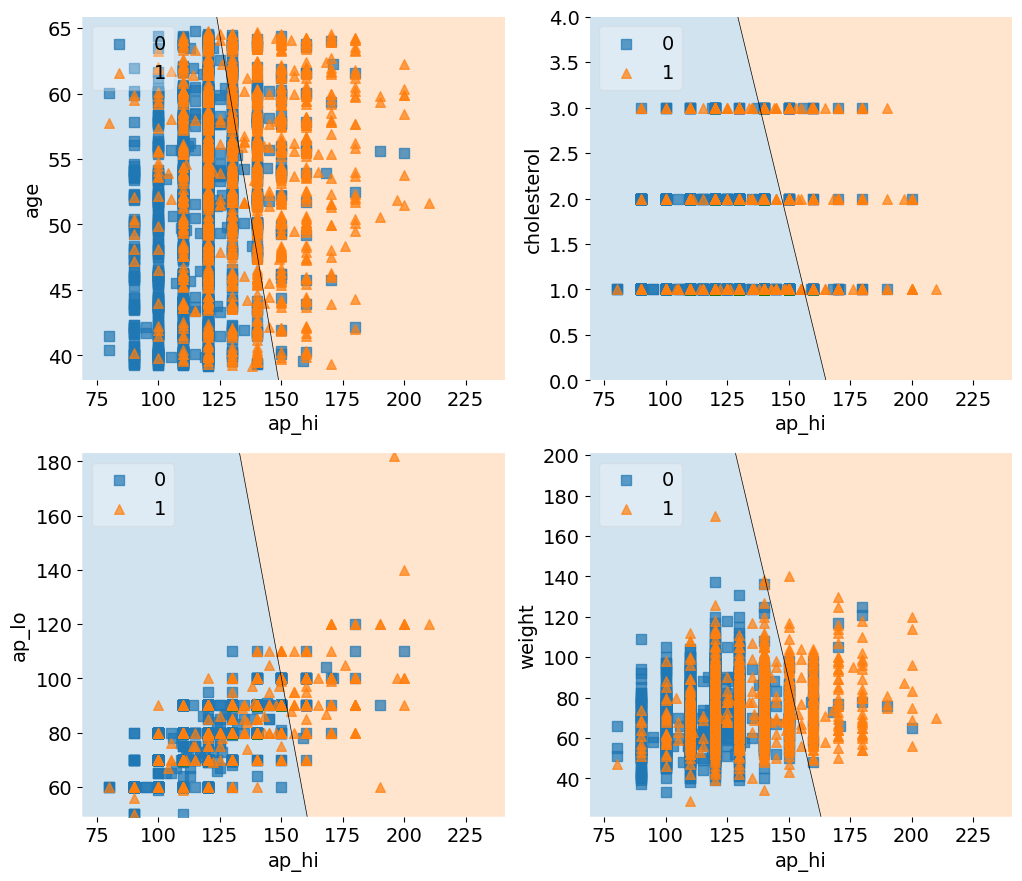

In [42]:
# now we compare the highest risk factor(ap_hi) with the following 4 most important risk factor(age,cholesterol, weight, ap_lo)
plt.rcParams.update({'font.size': 14})
fix,axarr = plt.subplots(2,2,figsize=(12,8),sharex=True,sharey=False)
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    ["ap_hi","age"],
    None,
    X_highlight,
    filler_feature_values,
    ax=axarr.flat[0]
)
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    ["ap_hi","cholesterol"],
    None,
    X_highlight,
    filler_feature_values,
    ax=axarr.flat[1]
)
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    ["ap_hi","ap_lo"],
    None,
    X_highlight,
    filler_feature_values,
    ax=axarr.flat[2]
)
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    ["ap_hi","weight"],
    None,
    X_highlight,
    filler_feature_values,
    ax=axarr.flat[3]
)

plt.subplots_adjust(top=1, bottom=0, hspace=0.2,wspace=0.2)
plt.show()

# para saber si 2 caracteristicas bastan para predecir el resultado mas o menos tienes que ver cuantos resultados se separan de la region de decisión(linea entre los 2 campos) y si
# esta bien distribuido entre todas las zonas de la grafica. En este caso solo lo cumple la primera. Además ultima grafica no está teniendo un patrñon vertical
# a medida que el peso aumenta. Esto sugiere que nos falta algo que será estudiado despues.

# Básicamente tienes que coger una prediccion por ejemplo positiva y ver si en las distintas graficas con ese par de datos se predice positivo o negativo. Por ejemplo en el caso de estudio 2872
# segun el libro se predice positivo pero solo vemos que en la primera grafica sale positivo mientras que en las otras 3 sale negativo indicandonos que al modelo le ha dado igual el par de valores
# de las 3 ultimas graficas y que solo con la predicción en la primera le ha bastado para considerarlo como positivo. (cuadrado = negativo, triangulo = positivo)

# En resumen, la región de decisión en regresión logística es la división en el espacio de entrada que determina cómo se asignan las instancias a las clases específicas, y esta división está definida
# por el límite de decisión derivado de los parámetros del modelo.

# a medida que aumenta la edad por ejemplo, la región azul se hace mas pequeña (CVD negativa), esto quiere decir que cada vez la probabilidad de una CVD es mayor. Los triangulos y cuadrados representan
# para ese x,y del dataset cual es el valor real (si positivo o negativo). Viendo en las graficas que el hiperplano de separación entre clases no es muy efectivo ya que no termina de separar bien.
# hay mucha mezcla en ambos lados

<Axes: xlabel='height [cm]', ylabel='weight [kg]'>

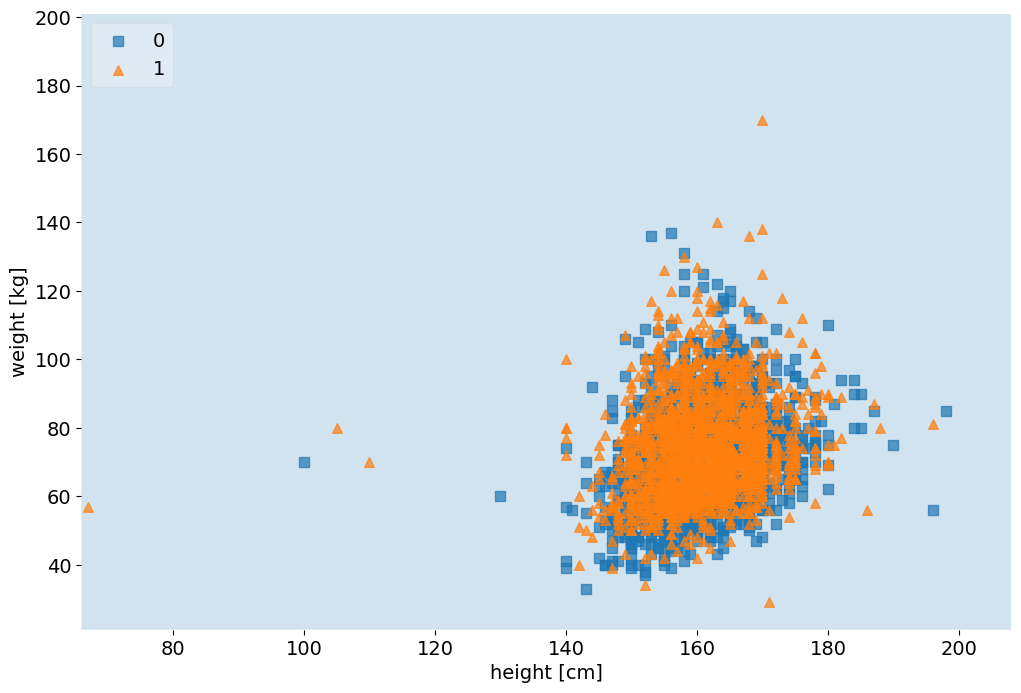

In [43]:
# analizando la grafica del ap_hi contra el peso vemos que no tiene un patron ascencente como el resto indicandonos que igual el peso
# por si solo no basta para concluir un resultado en especifico(esto se debe a que el peso tiene una fuerte relación también con la altura y hay que mirar ambas)
# a esto se le llama variable mediadora/mediante (mediating variable). Una variable que influye en la fuerza que tiene una variable independiente con otra dependiente(resultado)
# analizemos  la region de decision de peso vs altura para sacar nuestras conclusiones:
fig, ax = plt.subplots(1,1,figsize=(12,8))
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    [3,4],
    ["height [cm]","weight [kg]"],
    X_highlight,
    filler_feature_values,
    ax=ax
)

Vemos que no se ha producido ninguna región de decisión ya que pese a que el resto de variables se mantienenconstante(con los menores valores de riesgo) ninguna combinación de peso con altura es suficiente para predecir una CVD. Tambien vemos que laas predicciones de CVD se acumulan en un patron ovalado indicandonos que no hay relación lineal entre altura y peso siendo el BMI la relacion que realmente hay (Indice de masa corporal) BMI = peso(kg)/altura^2(m)

Como la relación entre el peso y la altura no es lineal y nuestro clasificador si lo es, vamos a tener un comportamiento pobre por tanto lo que podemo hacer es cambiar el clasificador por uno no lineal que va a reducir la interpretabilidad de nuestro modelo o bien sustituir estas variables por unas que si sean lineales. por ejemplo si sabemos que la relación entre 2 variables es exponencial, podemos substituirlas por su logaritmo. Vamos a lienarizar la realcion del peso y la altura usando mejor el Indice de masa corporal visto antes.

In [44]:
X2 = cvd_df.drop(['cardio'], axis=1).copy()
X2["bmi"] = X2["weight"] / (X2["height"]/100)**2

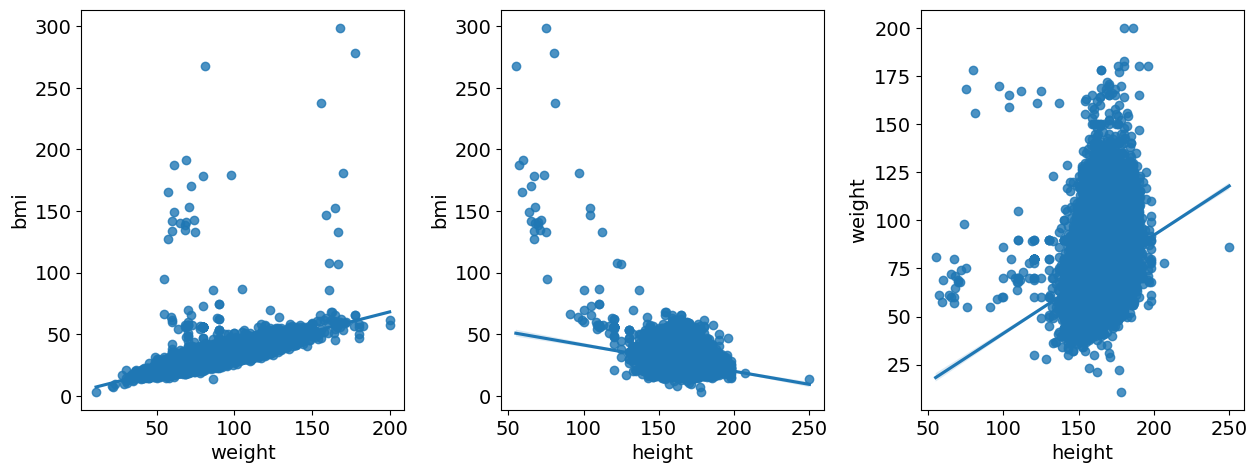

In [45]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))
sns.regplot(x="weight", y="bmi",data=X2, ax=ax1)
sns.regplot(x="height", y="bmi",data=X2, ax=ax2)
sns.regplot(x="height", y="weight",data=X2, ax=ax3)
plt.subplots_adjust(top=1,bottom=0, hspace=0.2, wspace=0.3)
plt.show()

In [46]:
# como podemos observar hay una mayor relacion lineal (muchos puntos cerca de la recta)

Optimization terminated successfully.
         Current function value: 0.562766
         Iterations 6


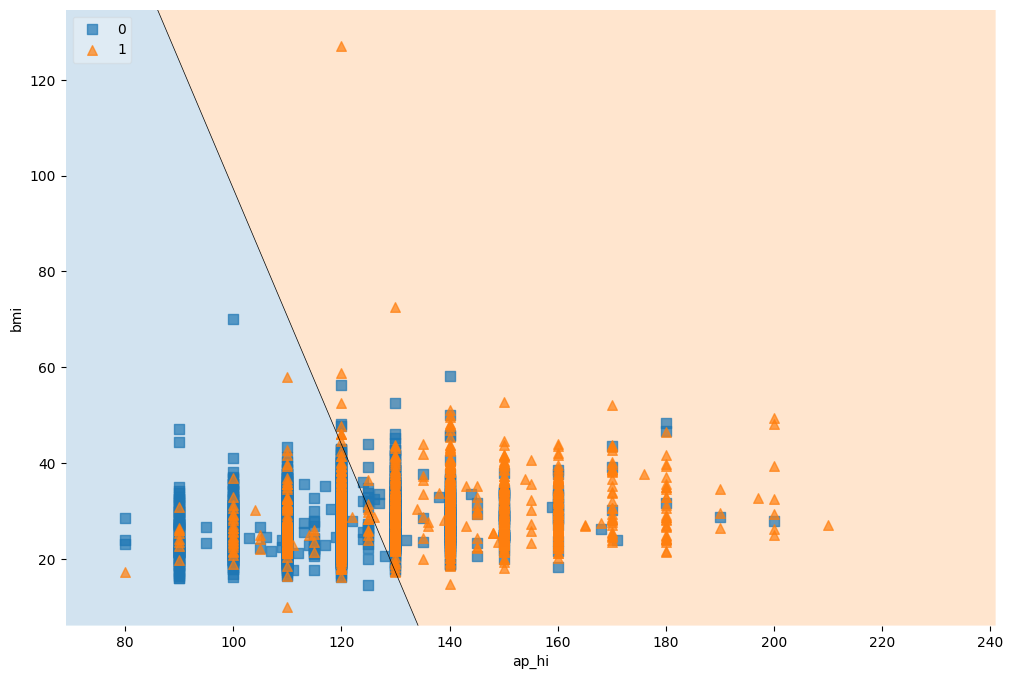

In [47]:
X2 = X2.drop(['weight','height'], axis=1)
X2_train, X2_test, _, _ = train_test_split(X2, y, test_size=0.15, random_state=9)
log_model2 = sm.Logit(y_train, sm.add_constant(X2_train))
log_result2 = log_model2.fit()

sns.reset_orig()
filler_feature_values2 = {"age": 60, "gender": 1, "ap_hi": 110, "ap_lo": 70, "cholesterol": 1, "gluc": 1,\
                          "smoke": 0, "alco":0, "active":1, "bmi":20}
X2_highlight = np.reshape(np.concatenate(([1],X2_test.iloc[2872].to_numpy())), (1, 11))

fig, ax = plt.subplots(1,1, figsize=(12,8))
mldatasets.create_decision_plot(X2_test, y_test, log_result2, ["ap_hi", "bmi"], None,
                     X2_highlight, filler_feature_values2, ax=ax)
plt.show()
# en el libro se mostraria como para el punto (la edad y bmi introducida del caso 2872) está en la región naranja(la que segun el modelo predice que con esos argumentos el resultado es una CVD) y que por
# tanto !podria¡ haber relacion entre estos datos y el resultado final. TAmbien destaca que hay  algunas anomalias ya que hay alga BMI en los datos representados bastante alto y que por ende
# podria estar funcionandom mal el modelo por está razon. Por ello habria que eliminar todos los datos anomalos o fuera de lo ordinario ya que podrian probocar fallos en el modelo y que perdiesemos confianza
# en nuestros datos. Por ello habria que eliminarlos como hicimos con los datos anomalos de la sangre. En la vida real, se haría igual.